In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load Dataset

In [3]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
!kaggle datasets download -d anaghachoudhari/pcos-detection-using-ultrasound-images

 84% 105M/126M [00:00<00:00, 212MB/s] 
100% 126M/126M [00:00<00:00, 204MB/s]


In [5]:
! unzip "pcos-detection-using-ultrasound-images.zip"

Archive:  pcos-detection-using-ultrasound-images.zip
  inflating: data/test/infected/OIP.jpg  
  inflating: data/test/infected/R.jpg  
  inflating: data/test/infected/WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg  
  inflating: data/test/infected/WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg  
  inflating: data/test/infected/WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg  
  inflating: data/test/infected/WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg  
  inflating: data/test/infected/img1.jpg  
  inflating: data/test/infected/img10.jpg  
  inflating: data/test/infected/img2.jpg  
  inflating: data/test/infected/img3.jpg  
  inflating: data/test/infected/img4.jpg  
  inflating: data/test/infected/img5.jpg  
  inflating: data/test/infected/img6.jpg  
  inflating: data/test/infected/img7.jpg  
  inflating: data/test/infected/img8.jpg  
  inflating: data/test/infected/img_0_1023.jpg  
  inflating: data/test/infected/img_0_1033.jpg  
  inflating: data/test/infected/img_0_1071.jpg  
  inflating: d

**Deleting corrupted images**

In [6]:
def is_valid_image(file_path):
    try:
        Image.open(file_path)
        return True
    except (IOError, SyntaxError):
        return False

def delete_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_valid_image(file_path):
                print(f"Deleting corrupted file: {file_path}")
                os.remove(file_path)

In [7]:
dataset_directory = "/content/data"
delete_corrupted_images(dataset_directory)

Deleting corrupted file: /content/data/test/infected/WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg
Deleting corrupted file: /content/data/test/infected/WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg
Deleting corrupted file: /content/data/test/infected/WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg
Deleting corrupted file: /content/data/test/infected/OIP.jpg
Deleting corrupted file: /content/data/test/infected/WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg
Deleting corrupted file: /content/data/test/infected/R.jpg
Deleting corrupted file: /content/data/test/notinfected/WhatsApp Image 2022-04-01 at 3.35.25 PM.jpeg
Deleting corrupted file: /content/data/test/notinfected/OIP (1).jpg
Deleting corrupted file: /content/data/test/notinfected/img_0_7.jpg
Deleting corrupted file: /content/data/test/notinfected/WhatsApp Image 2022-04-01 at 3.39.07 PM.jpeg


In [8]:
def resize_image(image_path, target_size):
    with Image.open(image_path) as img:
        resized_img = img.resize(target_size)
    return resized_img

target_size = (128, 128)

def resize_dir(dataset_directory, target_size):
  for filename in os.listdir(dataset_directory):
          # Construct the full file path
          image_path = os.path.join(dataset_directory, filename)
          # Resize the image
          resized_img = resize_image(image_path, target_size)
          resized_img.save(image_path)
          # Open the image file
          img = Image.open(image_path)
          # Convert the image to grayscale
          img_gray = img.convert('L')
          # Save the grayscale image
          img_gray.save(image_path)

  print("All images in " + dataset_directory + " resized and converted successfully!")

In [9]:
resize_dir("/content/data/train/infected", target_size)
resize_dir("/content/data/train/notinfected", target_size)
resize_dir("/content/data/test/infected", target_size)
resize_dir("/content/data/test/notinfected", target_size)

All images in /content/data/train/infected resized and converted successfully!
All images in /content/data/train/notinfected resized and converted successfully!
All images in /content/data/test/infected resized and converted successfully!
All images in /content/data/test/notinfected resized and converted successfully!


In [10]:
def check_image_size(image_path, target_size):
    with Image.open(image_path) as img:
        if img.size != target_size:
            print(f"Image {image_path} is not of target size. Expected {target_size}, got {img.size}.")

# Define the directory containing your images
dataset_directory = "/content/data"

# Loop through all files in the dataset directory and its subdirectories
for root, _, files in os.walk(dataset_directory):
    for file in files:
            # Construct the full file path
            image_path = os.path.join(root, file)

            # Check the image size
            check_image_size(image_path, target_size)

print("Checking completed.")

Checking completed.


In [11]:
from PIL import Image

# Open the image file
im = Image.open('/content/data/test/infected/img_0_8080.jpg')

# Print the image size
print(im.size)

(128, 128)


# Train and Test data

In [12]:
# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    '/content/data/train',
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    classes=['notinfected', 'infected'],
    color_mode='grayscale'
)

Found 1924 images belonging to 2 classes.


In [14]:
test_generator = test_datagen.flow_from_directory(
    '/content/data/test',
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    classes=['notinfected', 'infected'],
    color_mode='grayscale'
)

Found 1922 images belonging to 2 classes.


# New Image Segmentation based Classification Approach

In [21]:
def unet(input_size=(128, 128, 1)):  # Update input channels to 1 for grayscale images
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)

    features = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    model = Model(inputs=inputs, outputs=features)
    return model

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
# Train U-Net model as a feature extractor
unet_model = unet()
# Compile the model without specifying the loss function since we're not training it for segmentation
unet_model.compile(optimizer='adam')

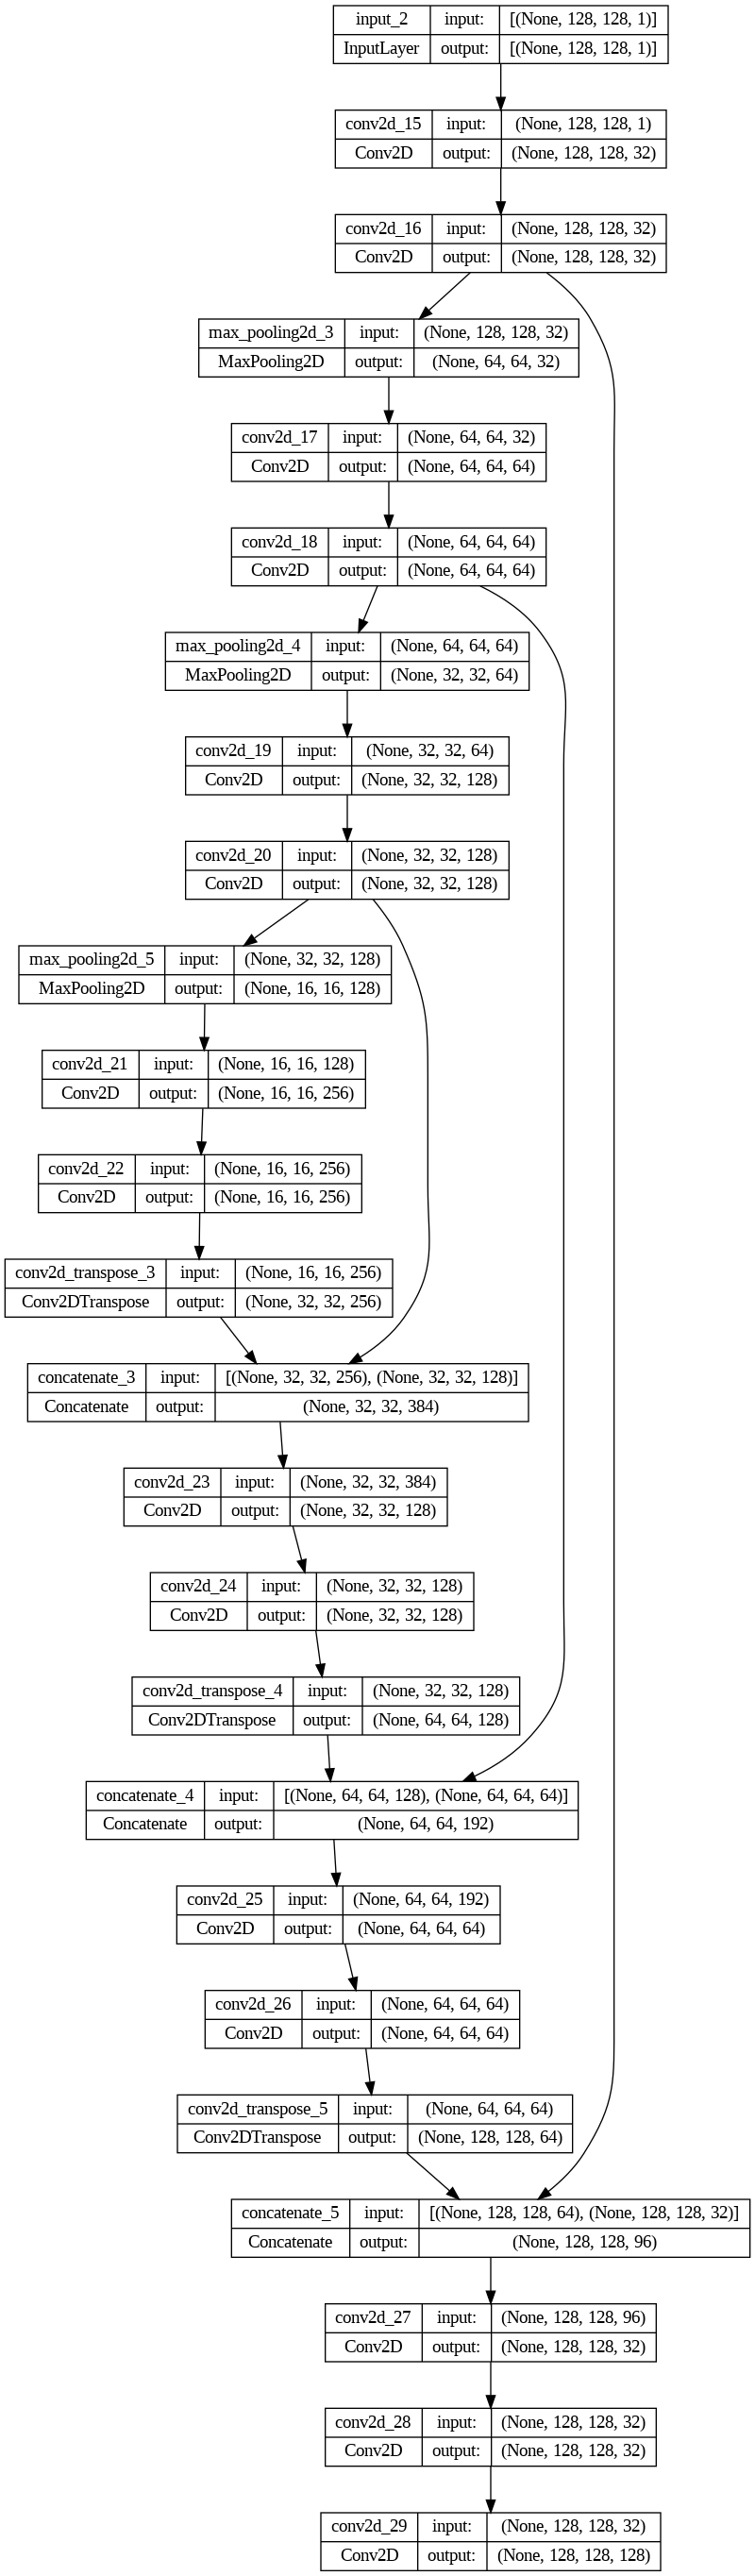

In [24]:
from keras.utils import plot_model

plot_model(unet_model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

In [25]:
# Define the number of batches to iterate over
num_batches = 5  # Adjust as needed

# Initialize lists to store infected and non-infected images
infected_images = []
non_infected_images = []

# Iterate over a specified number of batches from the train_generator
for _ in range(num_batches):
    images, labels = next(train_generator)
    for image, label in zip(images, labels):
        # Assuming class 'infected' is labeled as 1
        if label == 1:
            infected_images.append(image)
        else:
            non_infected_images.append(image)

infected_images = np.array(infected_images)
non_infected_images = np.array(non_infected_images)

In [26]:
# Extract features from the U-Net model
infected_features = unet_model.predict(infected_images)
# Save the features to a .npy file
np.save('infected_features.npy', infected_features)

2/2 [==============================] - 5s 133ms/step


In [27]:
non_infected_features = unet_model.predict(non_infected_images)
np.save('non_infected_features.npy', non_infected_features)

2/2 [==============================] - 7s 2s/step


Infected Features

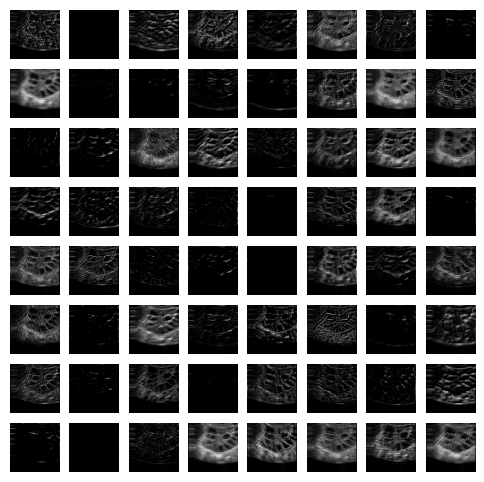

In [28]:
# Number of feature maps to plot
num_maps = 64
# Create a figure with subplots
fig, axs = plt.subplots(8, 8, figsize=(6, 6))

# Flatten the axes array
axs = axs.flatten()
# Plot each feature map
for i in range(num_maps):
    # Select the feature map
    feature_map = infected_features[0, :, :, i]
    # Plot the feature map
    axs[i].imshow(feature_map, cmap='gray')
    axs[i].axis('off')
# Remove the empty subplots
for i in range(num_maps, 64):
    fig.delaxes(axs[i])
plt.show()

Non-Infected Features

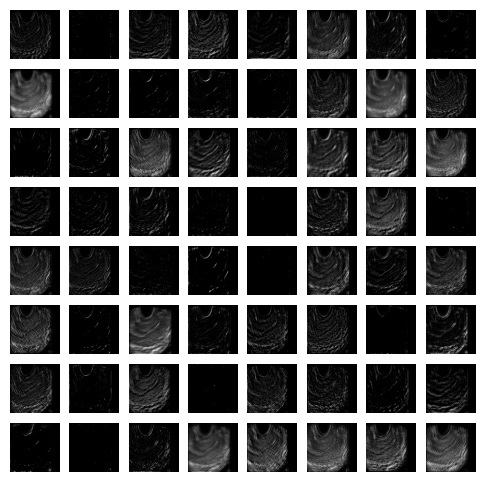

In [29]:
# Number of feature maps to plot
num_maps = 64
# Create a figure with subplots
fig, axs = plt.subplots(8, 8, figsize=(6, 6))

# Flatten the axes array
axs = axs.flatten()
# Plot each feature map
for i in range(num_maps):
    # Select the feature map
    feature_map = non_infected_features[0, :, :, i]
    # Plot the feature map
    axs[i].imshow(feature_map, cmap='gray')
    axs[i].axis('off')
# Remove the empty subplots
for i in range(num_maps, 64):
    fig.delaxes(axs[i])
plt.show()

# Memory Calculations

In [30]:
# Create a small sample of your data
sample_data = np.zeros((1, 128, 128, 1)) # Example for an image of size 10x10 with 3 channels
print('Memory requirement of a single data point: {} bytes'.format(sample_data.nbytes))

Memory requirement of a single data point: 131072 bytes


In [31]:
desired_batch_size = 1924 # Example batch size
total_memory_requirement = sample_data.nbytes * desired_batch_size
print('Total memory requirement for a batch of size {}: {} bytes'.format(desired_batch_size, total_memory_requirement))

Total memory requirement for a batch of size 1924: 252182528 bytes


In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.2Gi       9.9Gi       2.0Mi       1.6Gi        11Gi
Swap:             0B          0B          0B


In [32]:
import os
import psutil

# Function to get available memory in GB
def get_available_memory():
    mem = psutil.virtual_memory()
    return mem.available / (1024.0 ** 3) # Convert bytes to GB

# Calculate available memory
available_memory = get_available_memory()

# Memory requirement per batch in GB (based on your calculation)
memory_per_batch = 1 # 1 GB for a batch of size 1924

# Calculate maximum batch size that can fit into the available memory
max_batch_size = int(available_memory / memory_per_batch)

print(f"Available memory: {available_memory} GB")
print(f"Maximum batch size that can fit into the available memory: {max_batch_size}")


Available memory: 10.305305480957031 GB
Maximum batch size that can fit into the available memory: 10


In [33]:
batch_size = min(max_batch_size, 100000)
batch_size

10

# Binary Classification

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [35]:
# Load the features from the .npy files
infected_features= np.load('infected_features.npy')
non_infected_features = np.load('non_infected_features.npy')

In [44]:
infected_features_flat = infected_features.reshape(infected_features.shape[0], -1)
non_infected_features_flat = non_infected_features.reshape(non_infected_features.shape[0], -1)

In [45]:
# Combine the features and labels
features = np.concatenate([infected_features_flat, non_infected_features_flat])
labels = np.concatenate([np.ones(infected_features_flat.shape[0]), np.zeros(non_infected_features_flat.shape[0])])

In [46]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [47]:
features.shape[1]

2097152

In [48]:
# Define the binary classification model
binary_class_model = Sequential()
binary_class_model.add(Dense(128, activation='relu', input_shape=(features.shape[1],)))
binary_class_model.add(Dense(64, activation='relu'))
binary_class_model.add(Dense(1, activation='sigmoid'))

# Compile the model
binary_class_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
binary_class_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
2/2 [==============================] - 16s 6s/step - loss: 0.8014 - accuracy: 0.4219 - val_loss: 3.7139 - val_accuracy: 0.4375
Epoch 2/10
2/2 [==============================] - 12s 6s/step - loss: 1.8672 - accuracy: 0.6406 - val_loss: 0.2986 - val_accuracy: 0.9375
Epoch 3/10
2/2 [==============================] - 12s 6s/step - loss: 0.5483 - accuracy: 0.6875 - val_loss: 0.6721 - val_accuracy: 0.7500
Epoch 4/10
2/2 [==============================] - 20s 10s/step - loss: 0.3747 - accuracy: 0.8438 - val_loss: 0.4587 - val_accuracy: 0.8125
Epoch 5/10
2/2 [==============================] - 17s 8s/step - loss: 0.3608 - accuracy: 0.8750 - val_loss: 0.5723 - val_accuracy: 0.8125
Epoch 6/10
2/2 [==============================] - 11s 6s/step - loss: 0.3402 - accuracy: 0.8750 - val_loss: 0.2915 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 12s 6s/step - loss: 0.1386 - accuracy: 0.9531 - val_loss: 0.3586 - val_accuracy: 0.7500
Epoch 8/10
2/2 [=================

# Testing

In [49]:
# Define the number of batches to iterate over
num_batches = 5  # Adjust as needed

# Initialize lists to store infected and non-infected images
infected_images = []
non_infected_images = []

# Iterate over a specified number of batches from the train_generator
for _ in range(num_batches):
    images, labels = next(test_generator)
    for image, label in zip(images, labels):
        # Assuming class 'infected' is labeled as 1
        if label == 1:
            infected_images.append(image)
        else:
            non_infected_images.append(image)

infected_images = np.array(infected_images)
non_infected_images = np.array(non_infected_images)

In [50]:
# Extract features from the U-Net model
infected_features = unet_model.predict(infected_images)
# Save the features to a .npy file
np.save('test_infected_features.npy', infected_features)

2/2 [==============================] - 6s 590ms/step


In [51]:
non_infected_features = unet_model.predict(non_infected_images)
np.save('test_non_infected_features.npy', non_infected_features)

2/2 [==============================] - 7s 2s/step


In [52]:
infected_features_flat = infected_features.reshape(infected_features.shape[0], -1)
non_infected_features_flat = non_infected_features.reshape(non_infected_features.shape[0], -1)

In [53]:
# Combine the features and labels
features = np.concatenate([infected_features_flat, non_infected_features_flat])
labels = np.concatenate([np.ones(infected_features_flat.shape[0]), np.zeros(non_infected_features_flat.shape[0])])

In [54]:
# Combine the features and labels
combined = np.concatenate([features, labels.reshape(-1, 1)], axis=1)

# Shuffle the combined array
np.random.shuffle(combined)

# Split the shuffled combined array back into features and labels
X_test = combined[:, :-1]
y_test = combined[:, -1]

In [56]:
# Make predictions using the binary classification model
predictions = binary_class_model.predict(X_test)

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)

3/3 [==============================] - 2s 509ms/step


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [59]:
# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)
roc_auc = roc_auc_score(y_test, predictions) # predictions are probabilities

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.9375
Precision: 0.9393939393939394
Recall: 0.9117647058823529
F1 Score: 0.9253731343283583
ROC AUC Score: 0.9846547314578006
